## 결정트리 모델의 시각화

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Decision Tree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)

# iris 데이터 로딩, 학습/테스트 세트 분리
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

# 결정트리 분류기 학습
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [2]:
from sklearn.tree import export_graphviz

# tree.dot 파일을 생성
export_graphviz(dt_clf, out_file='tree.dot', class_names=iris_data.target_names,
               feature_names=iris_data.feature_names, impurity=True, filled=True)

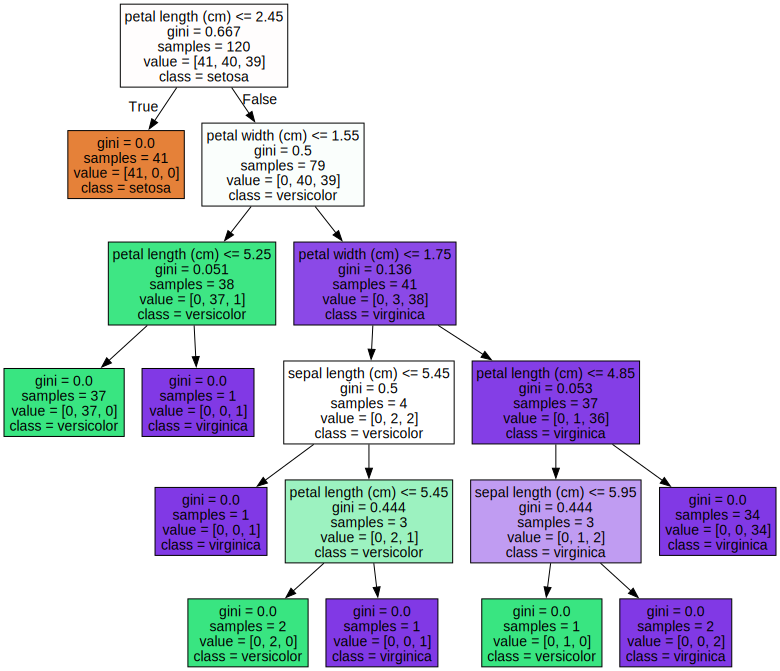

In [3]:
import graphviz

# 위에서 생성된 tree.dot 파일을 읽어서 시각화
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importances: 
[0.025 0.    0.555 0.42 ]
sepal length (cm) 0.025
sepal width (cm) 0.0
petal length (cm) 0.555
petal width (cm) 0.42


<Axes: >

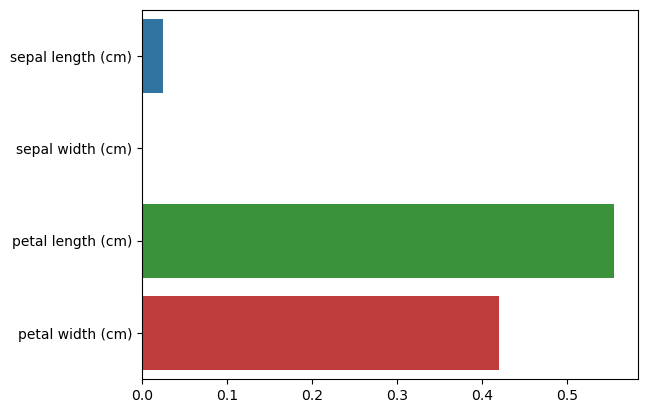

In [4]:
import seaborn as sns
import numpy as np

# feature importance 추출
print(f"Feature importances: \n{np.round(dt_clf.feature_importances_, 3)}")

# feature importance 별 레이블 맵핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print(name, np.round(value, 3))
    
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

## 결정트리의 과적합

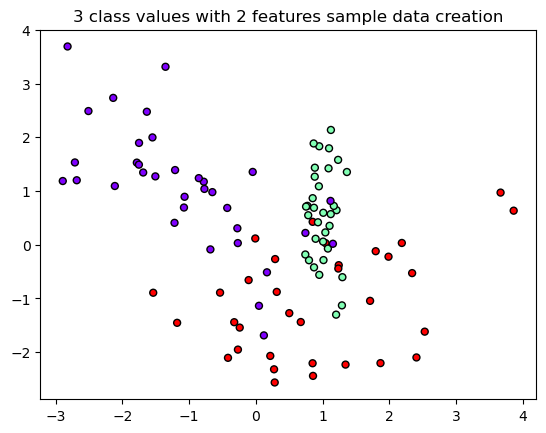

In [5]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

plt.title("3 class values with 2 features sample data creation")

# feature 2개, 결정값 클래스는 3가지 유형의 분류 샘플 데이터 생성
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolors='k')

In [6]:
import numpy as np

# classifier의 decision boundary를 시각화하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

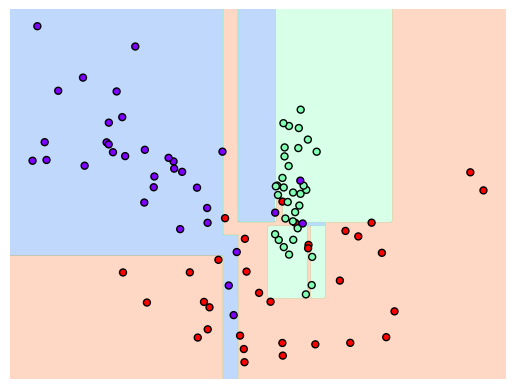

In [7]:
from sklearn.tree import DecisionTreeClassifier

# 하이퍼파라미터 디폴트로 수행한 결정트리 boundary 시각화
dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

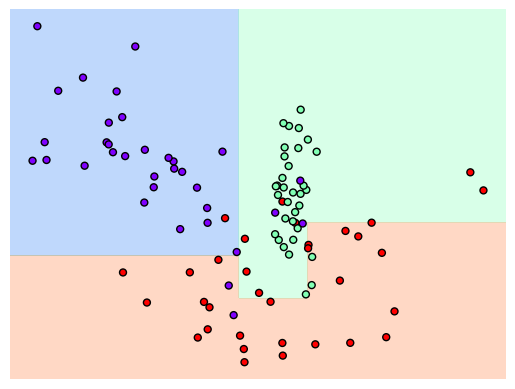

In [8]:
# min_samples_leaf = 6
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

## 결정트리실습 - Human Activity Recognition

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print("전체 피처명에서 10개 추출:\n", feature_name[:10])

전체 피처명에서 10개 추출:
 ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


### 중복된 피처명 확인 (생략)

In [10]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0],  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [11]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

### 모델 학습 및 정확도 측정

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print("결정트리 예측 정확도:", round(accuracy, 4))

# dt_clf의 학습에 사용된 하이퍼파라미터 추출
dt_clf.get_params()

결정트리 예측 정확도: 0.8548


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 156,
 'splitter': 'best'}

### GridSearchCV로 하이퍼파라미터 최적화

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [6, 8, 10, 12, 16, 20],
    'min_samples_split': [12]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치:', round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
# cv_results_ 속성을 데이터프레임으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# cv_results_ 에는 여러 값들이 있지만, 그 중 각 max_depth별 스코어 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

In [ ]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

# max_depth 값을 변화시키면서 루프로 성능 측정한 것과 비교
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(f"max depth={depth}의 정확도:", round(accuracy, 4))

In [ ]:
params = {
    'max_depth': [8, 12, 16, 20],
    'min_samples_split': [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring="accuracy", cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('최고 정확도:', round(grid_cv.best_score_))
print('최적 하이퍼 파라미터:', grid_cv.best_params_)

In [ ]:
best_dt_clf = grid_cv.best_estimator_
pred = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정트리 예측 정확도:', round(accuracy, 4))

In [ ]:
ftr_importances_values = best_dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_importances.sort_values(ascending=False)

In [ ]:
import seaborn as sns

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()